In [1]:
import torch
from tqdm import tqdm

In [2]:
import os
import sys

sys.path.append(os.path.pardir)

In [3]:
from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=40.0,  # 目標細胞面積 A_0
    L_0=30.0,  # 目標細胞周囲長 L_0
    T=10.0,  # 温度パラメータ T
    size =(96, 96)
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (16, 16), 'dim': 2, 'height': 16, 'width': 16, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 40.0, 'L_0': 25.0, 'T': 10.0, 'diffusion_channels': [2], 'other_channels': 1, 'diffusion_D': [0.1], 'diffusion_percent': [1.0]}


### 初期条件

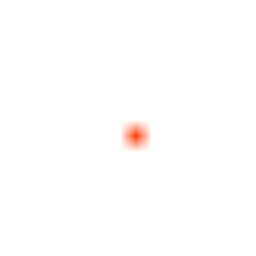

In [ ]:
cpm = CPM(config, device)  # CPMのインスタンスを作成
tensor = torch.zeros(
    (3, config.size[0], config.size[1], 3), device=device
)  # 初期状態のテンソルを作成
center = config.size[0] // 2  # 中心位置を計算
cell_num = 1  # 細胞IDを設定

for i in range(-1, 2):
    for j in range(-1, 2):
        tensor[:, center + i * 3, center + j * 3, 0] = cell_num  # 細胞IDを設定
        cell_num += 1
imshow_map(tensor[0])  # 初期状態を表示

### シュミレーション

ステップ: 100%|██████████| 500/500 [00:00<00:00, 562.79it/s]


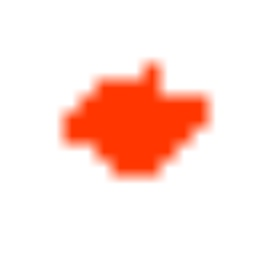

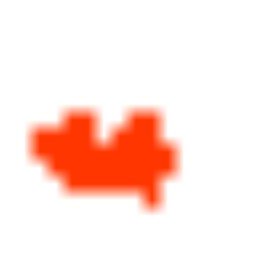

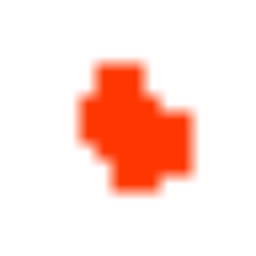

In [6]:
step = 500  # ステップ数
mcs_per_step = 1  # 1ステップあたりのMCS数

# オプション: 動画記録用ライターの初期化
video_filename = "../results/cpm_torch_jp.mp4"
writer = LoopWriter(filename=video_filename, fps=10)  # ループ動画ライター

# --- シミュレーション実行 ---
for i in tqdm(range(step), desc="ステップ"):
    for k in range(mcs_per_step):
        tensor = cpm.cpm_checkerboard_step_single_masked_func(tensor)

    # --- 動画フレーム追加 ---
    frame_rgb = map_tensor_to_rgb(tensor[0])
    zoomed = torch.tensor(zoom(frame_rgb, 4))  # 画像を4倍に拡大
    writer.add(zoomed)
    # imshow_map(tensor[0])  # 各ステップの状態を表示

writer.close()
imshow_map(tensor[0])
imshow_map(tensor[1])
imshow_map(tensor[2])

# 逆伝番